In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a27557cde25b1f82e25dc622d29c46c10ab15c9fcb821cc2d6a7d42ba81abee7
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler
import psutil
import time
import random
import math
import lime
import lime.lime_tabular

In [ ]:
DATASET_DIRECTORY = '/content/drive/MyDrive/research_paper/dataset/'

df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

df_dataframes = [pd.read_csv(DATASET_DIRECTORY + train_set) for train_set in df_sets]

rf_df = pd.concat(df_dataframes, axis=0)

summary_stats = rf_df.describe()

In [ ]:
summary_stats.T

count         mean        std          min  \
2344.615911050957    44999.0  2399.942852  47.933054  2195.022327   
1.9574423265130767   44999.0    -0.003795   3.001863   -11.867836   
-11.051929465903774  44999.0     0.136230  10.018179   -38.752193   
2423.5117862712      44999.0  2400.136396  48.124777  2210.757977   
-2.2754797717917516  44999.0     0.008793   2.999632   -12.069000   
-8.528997952577445   44999.0    -0.080621  10.006488   -45.609895   
2341.1017246483125   44999.0  2400.274438  47.814745  2210.082729   
2.5952265267603414   44999.0    -0.015069   2.998891   -13.127872   
-14.023894303097165  44999.0     0.025594   9.976182   -40.297279   
2366.446146425568    44999.0  2399.578947  47.879663  2206.149462   
-1.095272677252039   44999.0    -0.009680   2.997578   -11.713132   
10.161423421785784   44999.0    -0.032099   9.974283   -43.124337   
2431.767896332381    44999.0  2399.969898  48.049534  2198.900490   
2.8676329205273694   44999.0     0.003580   2.999440   -13.232126   
-22.067483064529085  44999.0     0.075583  10.002243   -38.743013   

                             25%          50%          75%          max  
2344.615911050957    2367.694958  2399.863764  2432.204942  2613.413440  
1.9574423265130767     -2.033317    -0.006213     2.028796    11.793667  
-11.051929465903774    -6.623464     0.163819     6.901243    37.783141  
2423.5117862712      2367.975170  2399.999410  2432.795490  2586.817655  
-2.2754797717917516    -2.012268     0.011625     2.040403    13.740709  
-8.528997952577445     -6.835284    -0.031722     6.662069    41.707004  
2341.1017246483125   2368.184517  2400.086062  2432.482341  2604.359828  
2.5952265267603414     -2.051254    -0.018837     2.012735    11.858345  
-14.023894303097165    -6.737246     0.026324     6.770981    45.136262  
2366.446146425568    2367.174654  2399.640220  2431.407890  2602.887251  
-1.095272677252039     -2.027731    -0.009977     1.997945    13.236755  
10.161423421785784     -6.816360    -0.043825     6.793200    43.028574  
2431.767896332381    2367.862664  2400.104028  2432.249082  2603.374793  
2.8676329205273694     -2.013805     0.010163     2.021921    13.216115  
-22.067483064529085    -6.672890     0.067312     6.808290    46.128664

In [ ]:
rf_df.head()

2344.615911050957  1.9574423265130767  -11.051929465903774  \
0        2370.816359           -2.094190             0.889730   
1        2417.816902            0.694941             6.865081   
2        2321.900235            0.581671            -3.735895   
3        2422.535924           -4.027744             2.180007   
4        2427.754466            0.869333             8.330654   

   2423.5117862712  -2.2754797717917516  -8.528997952577445  \
0              NaN                  NaN                 NaN   
1              NaN                  NaN                 NaN   
2              NaN                  NaN                 NaN   
3              NaN                  NaN                 NaN   
4              NaN                  NaN                 NaN   

   2341.1017246483125  2.5952265267603414  -14.023894303097165  \
0                 NaN                 NaN                  NaN   
1                 NaN                 NaN                  NaN   
2                 NaN                 NaN                  NaN   
3                 NaN                 NaN                  NaN   
4                 NaN                 NaN                  NaN   

   2366.446146425568  -1.095272677252039  10.161423421785784  \
0                NaN                 NaN                 NaN   
1                NaN                 NaN                 NaN   
2                NaN                 NaN                 NaN   
3                NaN                 NaN                 NaN   
4                NaN                 NaN                 NaN   

   2431.767896332381  2.8676329205273694  -22.067483064529085  
0                NaN                 NaN                  NaN  
1                NaN                 NaN                  NaN  
2                NaN                 NaN                  NaN  
3                NaN                 NaN                  NaN  
4                NaN                 NaN                  NaN

In [ ]:
rf_df.shape

(224995, 15)

In [ ]:
rf_df.isnull().sum()

2344.615911050957      179996
1.9574423265130767     179996
-11.051929465903774    179996
2423.5117862712        179996
-2.2754797717917516    179996
-8.528997952577445     179996
2341.1017246483125     179996
2.5952265267603414     179996
-14.023894303097165    179996
2366.446146425568      179996
-1.095272677252039     179996
10.161423421785784     179996
2431.767896332381      179996
2.8676329205273694     179996
-22.067483064529085    179996
dtype: int64

In [ ]:
df = rf_df.fillna(rf_df.mean())

In [ ]:
df.head()

2344.615911050957  1.9574423265130767  -11.051929465903774  \
0        2370.816359           -2.094190             0.889730   
1        2417.816902            0.694941             6.865081   
2        2321.900235            0.581671            -3.735895   
3        2422.535924           -4.027744             2.180007   
4        2427.754466            0.869333             8.330654   

   2423.5117862712  -2.2754797717917516  -8.528997952577445  \
0      2400.136396             0.008793           -0.080621   
1      2400.136396             0.008793           -0.080621   
2      2400.136396             0.008793           -0.080621   
3      2400.136396             0.008793           -0.080621   
4      2400.136396             0.008793           -0.080621   

   2341.1017246483125  2.5952265267603414  -14.023894303097165  \
0         2400.274438           -0.015069             0.025594   
1         2400.274438           -0.015069             0.025594   
2         2400.274438           -0.015069             0.025594   
3         2400.274438           -0.015069             0.025594   
4         2400.274438           -0.015069             0.025594   

   2366.446146425568  -1.095272677252039  10.161423421785784  \
0        2399.578947            -0.00968           -0.032099   
1        2399.578947            -0.00968           -0.032099   
2        2399.578947            -0.00968           -0.032099   
3        2399.578947            -0.00968           -0.032099   
4        2399.578947            -0.00968           -0.032099   

   2431.767896332381  2.8676329205273694  -22.067483064529085  
0        2399.969898             0.00358             0.075583  
1        2399.969898             0.00358             0.075583  
2        2399.969898             0.00358             0.075583  
3        2399.969898             0.00358             0.075583  
4        2399.969898             0.00358             0.075583

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_clusters = kmeans.fit_predict(df)

df['cluster'] = df_clusters

for label in df_clusters:
  if label == 0:
    df_clusters[label] = 1
  else:
    df_clusters[label] = 0

print(df['cluster'].value_counts())

cluster
1    196945
0     28050
Name: count, dtype: int64


In [ ]:
df.to_csv('/content/drive/MyDrive/research_paper/clustered_dataset.csv', index=False)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/research_paper/clustered_dataset.csv')

In [ ]:
dataset

2344.615911050957  1.9574423265130767  -11.051929465903774  \
0             2370.816359           -2.094190             0.889730   
1             2417.816902            0.694941             6.865081   
2             2321.900235            0.581671            -3.735895   
3             2422.535924           -4.027744             2.180007   
4             2427.754466            0.869333             8.330654   
...                   ...                 ...                  ...   
224990        2399.942852           -0.003795             0.136230   
224991        2399.942852           -0.003795             0.136230   
224992        2399.942852           -0.003795             0.136230   
224993        2399.942852           -0.003795             0.136230   
224994        2399.942852           -0.003795             0.136230   

        2423.5117862712  -2.2754797717917516  -8.528997952577445  \
0           2400.136396             0.008793           -0.080621   
1           2400.136396             0.008793           -0.080621   
2           2400.136396             0.008793           -0.080621   
3           2400.136396             0.008793           -0.080621   
4           2400.136396             0.008793           -0.080621   
...                 ...                  ...                 ...   
224990      2400.136396             0.008793           -0.080621   
224991      2400.136396             0.008793           -0.080621   
224992      2400.136396             0.008793           -0.080621   
224993      2400.136396             0.008793           -0.080621   
224994      2400.136396             0.008793           -0.080621   

        2341.1017246483125  2.5952265267603414  -14.023894303097165  \
0              2400.274438           -0.015069             0.025594   
1              2400.274438           -0.015069             0.025594   
2              2400.274438           -0.015069             0.025594   
3              2400.274438           -0.015069             0.025594   
4              2400.274438           -0.015069             0.025594   
...                    ...                 ...                  ...   
224990         2400.274438           -0.015069             0.025594   
224991         2400.274438           -0.015069             0.025594   
224992         2400.274438           -0.015069             0.025594   
224993         2400.274438           -0.015069             0.025594   
224994         2400.274438           -0.015069             0.025594   

        2366.446146425568  -1.095272677252039  10.161423421785784  \
0             2399.578947            -0.00968           -0.032099   
1             2399.578947            -0.00968           -0.032099   
2             2399.578947            -0.00968           -0.032099   
3             2399.578947            -0.00968           -0.032099   
4             2399.578947            -0.00968           -0.032099   
...                   ...                 ...                 ...   
224990        2399.578947            -0.00968           -0.032099   
224991        2399.578947            -0.00968           -0.032099   
224992        2399.578947            -0.00968           -0.032099   
224993        2399.578947            -0.00968           -0.032099   
224994        2399.578947            -0.00968           -0.032099   

        2431.767896332381  2.8676329205273694  -22.067483064529085  cluster  
0             2399.969898            0.003580             0.075583        1  
1             2399.969898            0.003580             0.075583        1  
2             2399.969898            0.003580             0.075583        1  
3             2399.969898            0.003580             0.075583        1  
4             2399.969898            0.003580             0.075583        1  
...                   ...                 ...                  ...      ...  
224990        2420.159605            2.013011            -5.583688        1  
224991        2434.940686           -3.75143

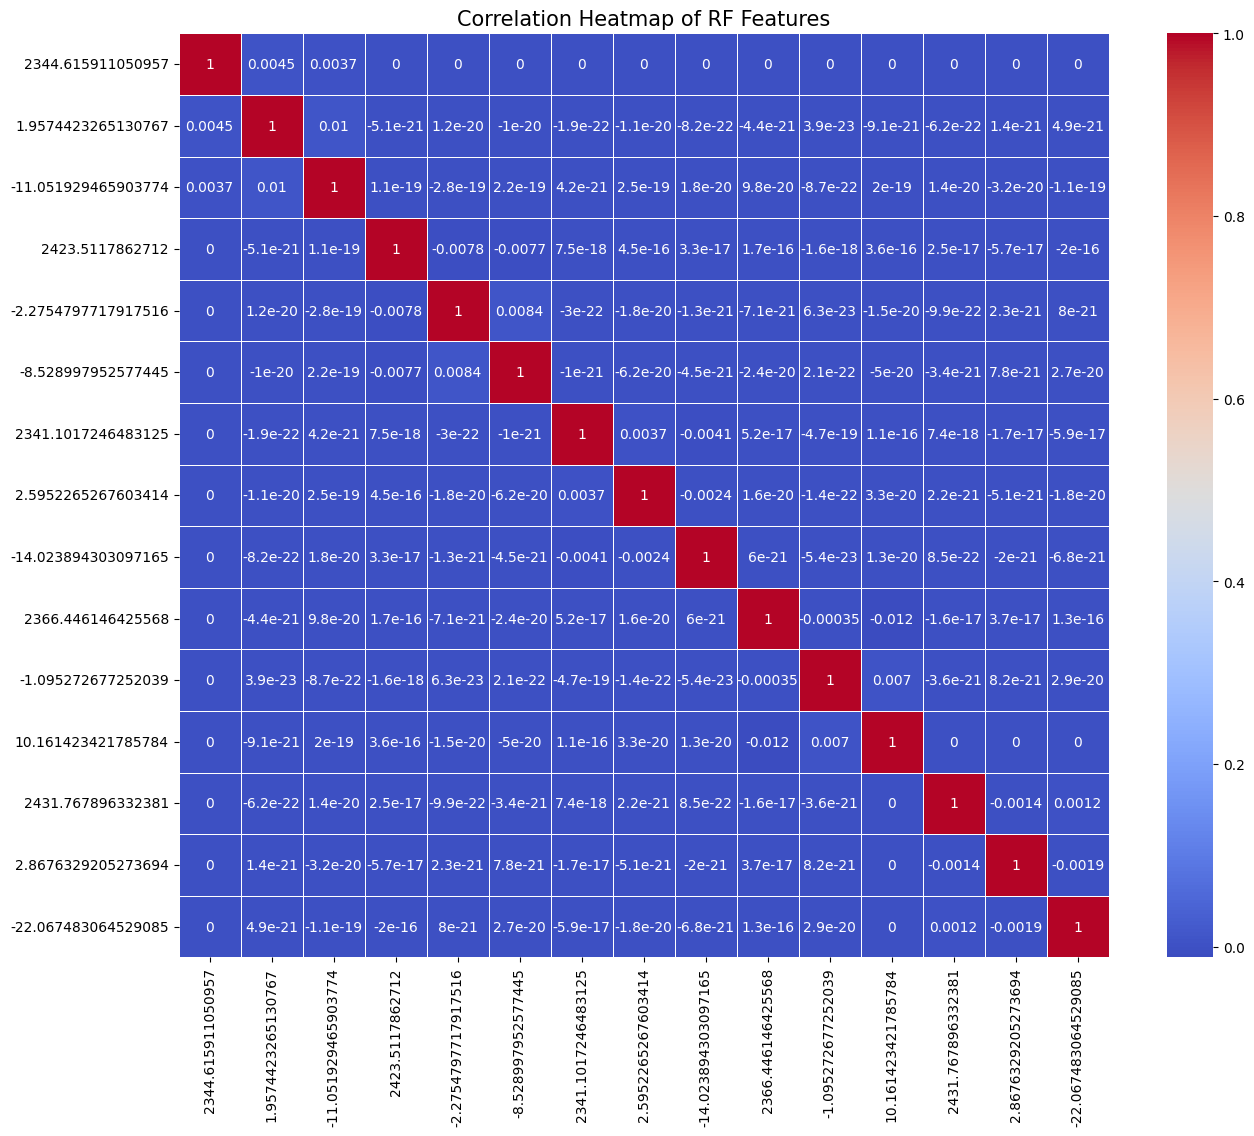

In [ ]:
import seaborn as sns

correlation_matrix = dataset.drop(['cluster'], axis=1).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title("Correlation Heatmap of RF Features", size=15)

plt.show()

In [ ]:
X = dataset.drop(['cluster'], axis=1)
y = dataset['cluster']

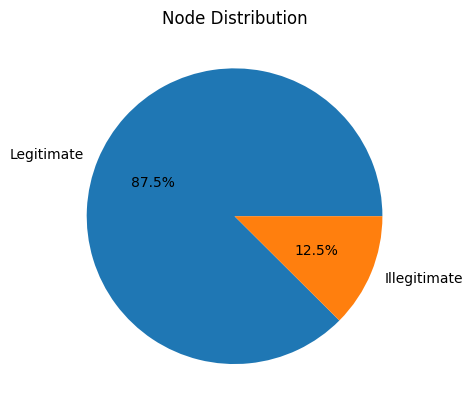

In [ ]:
graph_labels = 'Legitimate', 'Illegitimate'
graph_y = y.value_counts()
fig, ax = plt.subplots()
ax.pie(graph_y, labels=graph_labels, autopct='%1.1f%%')
plt.title('Node Distribution')
plt.show()

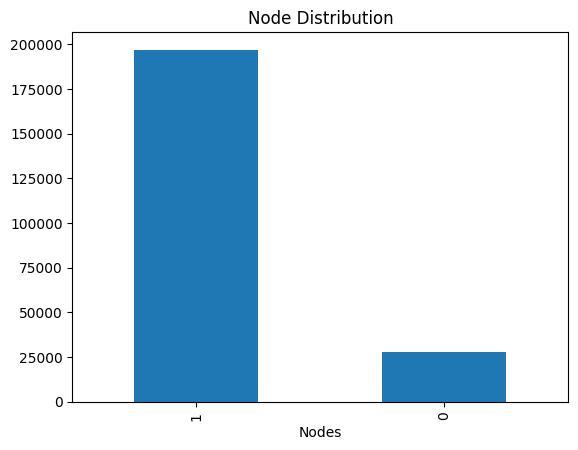

In [ ]:
graph_y.plot(kind='bar', xlabel='Nodes')
plt.title('Node Distribution')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y.iloc[idx]
        return x, y

In [ ]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DNN-BiLSTM

In [ ]:
class DNNBiLSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim=64, output_dim=2):
    super(DNNBiLSTM, self).__init__()
    self.dnn = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, hidden_dim)
        )
    self.bilstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)

  def forward(self, x):
    x = self.dnn(x)
    x = x.unsqueeze(1)
    lstm_out, _ = self.bilstm(x)
    lstm_out = lstm_out[:, -1, :]
    output = self.fc(lstm_out)
    return output

  def predict_proba(self, x):
      with torch.no_grad():
          x = torch.tensor(x, dtype=torch.float32)
          output = self.forward(x)
          probabilities = F.softmax(output, dim=1).numpy()
          return probabilities

In [ ]:
model = DNNBiLSTM(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader, val_dataset, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            x, y = batch
            x = x.float()
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x = x.float()
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset)
        print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy:.4f}')

In [ ]:
train(model, train_loader, val_loader, val_dataset, criterion, optimizer, epochs=20)

Epoch 1, Loss: 0.021958495683857715
Validation Loss: 0.008481994473454369, Accuracy: 0.9964
Epoch 2, Loss: 0.007270400311972177
Validation Loss: 0.004619549008993014, Accuracy: 0.9986
Epoch 3, Loss: 0.005982625990889776
Validation Loss: 0.003818010540806355, Accuracy: 0.9986
Epoch 4, Loss: 0.005240041362981376
Validation Loss: 0.004693896955712756, Accuracy: 0.9978
Epoch 5, Loss: 0.004873040308756673
Validation Loss: 0.003158375464893928, Accuracy: 0.9988
Epoch 6, Loss: 0.00473242376024584
Validation Loss: 0.0032437780402670307, Accuracy: 0.9988
Epoch 7, Loss: 0.0045981885154983
Validation Loss: 0.003979811111169949, Accuracy: 0.9983
Epoch 8, Loss: 0.004234025122137256
Validation Loss: 0.006951398196882596, Accuracy: 0.9974
Epoch 9, Loss: 0.00405598692829666
Validation Loss: 0.003456107500240971, Accuracy: 0.9983
Epoch 10, Loss: 0.003889008040776515
Validation Loss: 0.003863411991472972, Accuracy: 0.9983
Epoch 11, Loss: 0.0038508816413980185
Validation Loss: 0.0025803246903490103, Accu

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.float()
            y = y.long()
            outputs = model(x)
            loss = nn.CrossEntropyLoss()(outputs, y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            labels.extend(y.cpu().numpy())

    accuracy = correct / len(test_loader.dataset)
    precision = precision_score(labels, predictions, zero_division=False)
    recall = recall_score(labels, predictions, zero_division=False)
    f1 = f1_score(labels, predictions, zero_division=False)

    print(f'Test Loss: {test_loss / len(test_loader)}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('Classification Report:')
    print(classification_report(labels, predictions))

    confusions = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusions, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


Test Loss: 0.004147089424851969
Test Accuracy: 0.9983
Precision: 0.9988
Recall: 0.9993
F1 Score: 0.9990
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5560
           1       1.00      1.00      1.00     39439

    accuracy                           1.00     44999
   macro avg       1.00      1.00      1.00     44999
weighted avg       1.00      1.00      1.00     44999



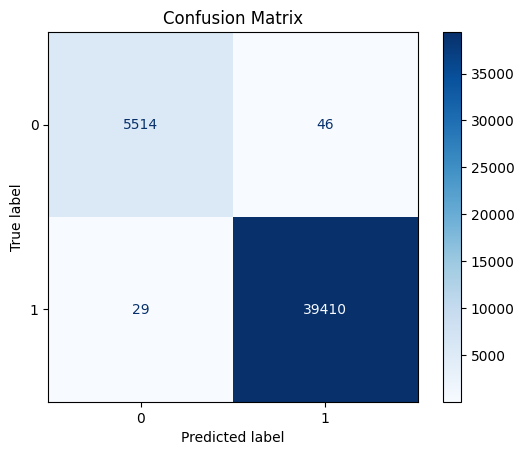

In [ ]:
evaluate_model(model, test_loader)

###Fitness (Objective) Function

In [ ]:
def train_on_selected_features(selected_features, X, y, epochs=20, batch_size=32):
    selected_features_indices = np.where(selected_features)[0]
    X_selected = X.iloc[:, selected_features_indices]

    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_dataset1 = MyDataset(X_train, y_train)
    train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True)
    val_dataset1 = MyDataset(X_val, y_val)
    val_loader1 = DataLoader(val_dataset1, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    model = DNNBiLSTM(input_dim=input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader1:
            x, y = batch
            x = x.float()
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader1:
                x, y = batch
                x = x.float()
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset1)

        return 1 - accuracy

In [ ]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

### GA

In [ ]:
def crossover(individualLength, parent1, parent2):
    crossover_point = random.randint(1, individualLength - 1)
    offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return offspring1, offspring2

In [ ]:
def mutation(individual, individualLength, lb, ub):
    mutationIndex = random.randint(0, individualLength - 1)
    individual[mutationIndex] = 1 - individual[mutationIndex]

In [ ]:
def pairSelection(population, scores, popSize):
    def rouletteWheelSelectionId(scores, popSize):
        total_fitness = sum(scores)
        normalized_scores = [score / total_fitness for score in scores]
        cumulative_probs = np.cumsum(normalized_scores)
        random_num = random.random()
        for i, cumulative_prob in enumerate(cumulative_probs):
            if random_num <= cumulative_prob:
                return i

    parent1Id = rouletteWheelSelectionId(scores, popSize)
    parent1 = population[parent1Id].copy()

    parent2Id = parent1Id
    while parent2Id == parent1Id:
        parent2Id = rouletteWheelSelectionId(scores, popSize)

    parent2 = population[parent2Id].copy()

    return parent1, parent2

In [ ]:
def mutatePopulaton(population, popSize, mutationProbability, keep, lb, ub):
    for i in range(keep, popSize):
        if random.random() < mutationProbability:
            mutation(population[i], len(population[i]), lb, ub)

In [ ]:
def sortPopulation(population, scores):
    sorted_indices = scores.argsort()
    population = population[sorted_indices]
    scores = scores[sorted_indices]
    return population, scores

In [ ]:
def crossoverPopulaton(population, scores, popSize, crossoverProbability, keep):
    newPopulation = np.zeros_like(population)
    newPopulation[:keep] = population[:keep]

    for i in range(keep, popSize, 2):
        parent1, parent2 = pairSelection(population, scores, popSize)
        individualLength = len(parent1)

        if random.random() < crossoverProbability:
            offspring1, offspring2 = crossover(individualLength, parent1, parent2)
        else:
            offspring1, offspring2 = parent1.copy(), parent2.copy()

        newPopulation[i] = offspring1
        if i + 1 < popSize:
            newPopulation[i + 1] = offspring2

    return newPopulation

In [ ]:
def clearDups(population, lb, ub):
    unique_population = np.unique(population, axis=0)
    num_duplicates = len(population) - len(unique_population)

    if num_duplicates > 0:
        random_individuals = np.random.randint(2, size=(num_duplicates, population.shape[1]))
        unique_population = np.vstack((unique_population, random_individuals))

    return unique_population

In [ ]:
def GA(objf, lb, ub, dim, popSize, iters):
    cp = 0.8
    mp = 0.05
    keep = 2
    s = solution()

    bestScore = float("inf")
    bestIndividual = None

    ga = np.random.randint(2, size=(popSize, dim))
    convergence_curve = np.zeros(iters)

    print('GA is optimizing "' + objf.__name__ + '" for feature selection')

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(iters):
        scores = np.array([objf(ind) for ind in ga])

        ga, scores = sortPopulation(ga, scores)

        if scores[0] < bestScore:
            bestScore = scores[0]
            bestIndividual = ga[0]

        convergence_curve[l] = bestScore

        if l % 1 == 0:
            print(f"Iteration {l + 1}, best fitness (error): {bestScore}")

        ga = crossoverPopulaton(ga, scores, popSize, cp, keep)
        mutatePopulaton(ga, popSize, mp, keep, lb, ub)
        ga = clearDups(ga, lb, ub)

    timerEnd = time.time()
    s.bestIndividual = bestIndividual
    s.bestScore = bestScore
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "GA"
    s.objfname = objf.__name__

    return s

In [ ]:
dim = X.shape[1]
lb = [0] * dim
ub = [1] * dim
popSize = 10
iters = 5

In [ ]:
def objective(selected_features):
  return train_on_selected_features(selected_features, X, y)

In [ ]:
best_solution = GA(objective, lb, ub, dim, popSize, iters)

print(f"Best feature set: {best_solution.bestIndividual}")
print(f"Best accuracy (1 - best error): {1 - best_solution.bestScore}")

GA is optimizing "objective" for feature selection
Iteration 1, best fitness (error): 0.0010277777777777386
Iteration 2, best fitness (error): 0.0010277777777777386
Iteration 3, best fitness (error): 0.0010277777777777386
Iteration 4, best fitness (error): 0.0010277777777777386
Iteration 5, best fitness (error): 0.0010277777777777386
Best feature set: [0 1 1 1 0 0 1 0 1 1 1 0 1 1 0]
Best accuracy (1 - best error): 0.9989722222222223


###GWO

In [ ]:
def GWO(objf, lb, ub, dim, SearchAgents_no, Max_iter):
    Alpha_pos = np.zeros(dim)
    Alpha_score = float("inf")

    Beta_pos = np.zeros(dim)
    Beta_score = float("inf")

    Delta_pos = np.zeros(dim)
    Delta_score = float("inf")

    Positions = np.random.randint(0, 2, (SearchAgents_no, dim))

    Convergence_curve = np.zeros(Max_iter)
    s = solution()

    print('GWO is optimizing  "' + objf.__name__ + '"')
    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(Max_iter):
        for i in range(SearchAgents_no):
            fitness = objf(Positions[i])

            if fitness < Alpha_score:
                Delta_score = Beta_score
                Delta_pos = Beta_pos.copy()
                Beta_score = Alpha_score
                Beta_pos = Alpha_pos.copy()
                Alpha_score = fitness
                Alpha_pos = Positions[i].copy()

            elif fitness < Beta_score:
                Delta_score = Beta_score
                Delta_pos = Beta_pos.copy()
                Beta_score = fitness
                Beta_pos = Positions[i].copy()

            elif fitness < Delta_score:
                Delta_score = fitness
                Delta_pos = Positions[i].copy()

        a = 2 - l * ((2) / Max_iter)

        for i in range(SearchAgents_no):
            for j in range(dim):
                r1, r2 = random.random(), random.random()
                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                X1 = Alpha_pos[j] - A1 * D_alpha

                r1, r2 = random.random(), random.random()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                X2 = Beta_pos[j] - A2 * D_beta

                r1, r2 = random.random(), random.random()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C3 * Delta_pos[j] - Positions[i, j])
                X3 = Delta_pos[j] - A3 * D_delta

                Positions[i, j] = 1 if ((X1 + X2 + X3) / 3) > 0.5 else 0

        Convergence_curve[l] = Alpha_score

        if l % 1 == 0:
            print(f"At iteration {l}, the best fitness is {Alpha_score:.4f}")

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = Convergence_curve
    s.optimizer = "GWO"
    s.bestIndividual = Alpha_pos
    s.objfname = objf.__name__

    return s

In [ ]:
s = GWO(objective, lb=0, ub=1, dim=15, SearchAgents_no=10, Max_iter=5)
print("Best Features Selected:", [i for i, x in enumerate(s.bestIndividual) if x == 1])
print("Best Fitness Score:", min(s.convergence))
print("Best Accuracy:", 1 - min(s.convergence))

GWO is optimizing  "objective"
At iteration 0, the best fitness is 0.0022
At iteration 1, the best fitness is 0.0021
At iteration 2, the best fitness is 0.0007
At iteration 3, the best fitness is 0.0007
At iteration 4, the best fitness is 0.0007
Best Features Selected: [1, 3, 6, 7, 9, 10, 11]
Best Fitness Score: 0.000694444444444442
Best Accuracy: 0.9993055555555556


In [ ]:
selected_features_ga = best_solution.bestIndividual
selected_features_gwo = s.bestIndividual

In [ ]:
selected_features_ga

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0])

In [ ]:
selected_features_gwo

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
selected_features_ga_original = [X.columns[i] for i, x in enumerate(selected_features_ga) if x == 1]
print(selected_features_ga_original)
print(len(selected_features_ga_original))

['1.9574423265130767', '-11.051929465903774', '2423.5117862712', '2341.1017246483125', '-14.023894303097165', '2366.446146425568', '-1.095272677252039', '2431.767896332381', '2.8676329205273694']
9


In [ ]:
selected_features_gwo_original = [X.columns[i] for i, x in enumerate(selected_features_gwo) if x == 1]
print(selected_features_gwo_original)
print(len(selected_features_gwo_original))

['1.9574423265130767', '2423.5117862712', '2341.1017246483125', '2.5952265267603414', '2366.446146425568', '-1.095272677252039', '10.161423421785784']
7


In [ ]:
weights_ga = [1 if x in selected_features_ga_original else 0 for x in X.columns]
print(weights_ga)

[0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]


In [ ]:
weights_gwo = [1 if x in selected_features_gwo_original else 0 for x in X.columns]
print(weights_gwo)

[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]


In [ ]:
combined_weights = [max(x, y) for x, y in zip(weights_ga, weights_gwo)]

In [ ]:
combined_features = [x for x, w in zip(X.columns, combined_weights) if w > 0]

In [ ]:
combined_features

['2344.615911050957',
 '1.9574423265130767',
 '2423.5117862712',
 '2341.1017246483125',
 '2.5952265267603414',
 '2366.446146425568',
 '2431.767896332381',
 '2.8676329205273694',
 '-22.067483064529085']

In [ ]:
len(combined_features)

9

### GA Features

In [ ]:
ga_features_indices = [X.columns.get_loc(col) for col in selected_features_ga_original]

In [ ]:
X_selected_ga = X.iloc[:, ga_features_indices]

In [ ]:
X_train_selected_ga, X_test_selected_ga, y_train_selected_ga, y_test_selected_ga = train_test_split(X_selected_ga, y, test_size=0.3, random_state=42)
X_train_selected_ga, X_val_selected_ga, y_train_selected_ga, y_val_selected_ga = train_test_split(X_train_selected_ga, y_train_selected_ga, test_size=0.2, random_state=42)

In [ ]:
X_train_selected_ga = scaler.fit_transform(X_train_selected_ga)
X_test_selected_ga = scaler.transform(X_test_selected_ga)
X_val_selected_ga = scaler.transform(X_val_selected_ga)

In [ ]:
gwo_features_indices = [X.columns.get_loc(col) for col in selected_features_gwo_original]

In [ ]:
train_dataset_selected_ga = MyDataset(X_train_selected_ga, y_train_selected_ga)
train_loader_selected_ga = DataLoader(train_dataset_selected_ga, batch_size=64, shuffle=True)
test_dataset_selected_ga = MyDataset(X_test_selected_ga, y_test_selected_ga)
test_loader_selected_ga = DataLoader(test_dataset_selected_ga, batch_size=64, shuffle=False)
val_dataset_selected_ga = MyDataset(X_val_selected_ga, y_val_selected_ga)
val_loader_selected_ga = DataLoader(val_dataset_selected_ga, batch_size=64, shuffle=False)

In [ ]:
model_selected_ga = DNNBiLSTM(input_dim=X_train_selected_ga.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer_selected_ga = optim.Adam(model_selected_ga.parameters(), lr=0.001)

In [ ]:
train(model_selected_ga, train_loader_selected_ga, val_loader_selected_ga, val_dataset_selected_ga, criterion, optimizer_selected_ga, epochs=20)

Epoch 1, Loss: 0.01744171809469925
Validation Loss: 0.003514435624705712, Accuracy: 0.9986
Epoch 2, Loss: 0.004942999650137487
Validation Loss: 0.003206803005796744, Accuracy: 0.9988
Epoch 3, Loss: 0.004120863923620899
Validation Loss: 0.0021091732003990517, Accuracy: 0.9995
Epoch 4, Loss: 0.003678911947392526
Validation Loss: 0.003538115933411866, Accuracy: 0.9983
Epoch 5, Loss: 0.003143323961021912
Validation Loss: 0.0031271951278636126, Accuracy: 0.9986
Epoch 6, Loss: 0.003130746132272809
Validation Loss: 0.010007764987955147, Accuracy: 0.9975
Epoch 7, Loss: 0.0029691217303771454
Validation Loss: 0.010199299472824983, Accuracy: 0.9970
Epoch 8, Loss: 0.002826505617444808
Validation Loss: 0.003988897204407512, Accuracy: 0.9984
Epoch 9, Loss: 0.0025853120317215076
Validation Loss: 0.0020652520217483844, Accuracy: 0.9990
Epoch 10, Loss: 0.00263579448493385
Validation Loss: 0.0017240528897365965, Accuracy: 0.9994
Epoch 11, Loss: 0.0022633442925330213
Validation Loss: 0.002551555708044045

Test Loss: 0.0016909714225834406
Test Accuracy: 0.9992
Precision: 0.9995
Recall: 0.9996
F1 Score: 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8304
           1       1.00      1.00      1.00     59195

    accuracy                           1.00     67499
   macro avg       1.00      1.00      1.00     67499
weighted avg       1.00      1.00      1.00     67499



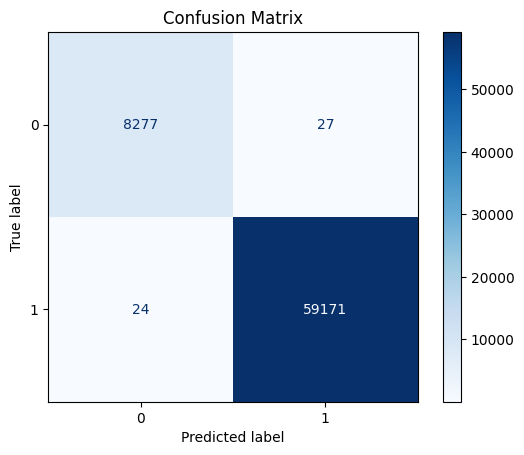

In [ ]:
evaluate_model(model_selected_ga, test_loader_selected_ga)

### GWO Features

In [ ]:
X_selected_gwo = X.iloc[:, gwo_features_indices]

In [ ]:
X_train_selected_gwo, X_test_selected_gwo, y_train_selected_gwo, y_test_selected_gwo = train_test_split(X_selected_gwo, y, test_size=0.3, random_state=42)
X_train_selected_gwo, X_val_selected_gwo, y_train_selected_gwo, y_val_selected_gwo = train_test_split(X_train_selected_gwo, y_train_selected_gwo, test_size=0.2, random_state=42)

In [ ]:
X_train_selected_gwo = scaler.fit_transform(X_train_selected_gwo)
X_test_selected_gwo = scaler.transform(X_test_selected_gwo)
X_val_selected_gwo = scaler.transform(X_val_selected_gwo)

In [ ]:
train_dataset_selected_gwo = MyDataset(X_train_selected_gwo, y_train_selected_gwo)
train_loader_selected_gwo = DataLoader(train_dataset_selected_gwo, batch_size=64, shuffle=True)
test_dataset_selected_gwo = MyDataset(X_test_selected_gwo, y_test_selected_gwo)
test_loader_selected_gwo = DataLoader(test_dataset_selected_gwo, batch_size=64, shuffle=False)
val_dataset_selected_gwo = MyDataset(X_val_selected_gwo, y_val_selected_gwo)
val_loader_selected_gwo = DataLoader(val_dataset_selected_gwo, batch_size=64, shuffle=False)

In [ ]:
model_selected_gwo = DNNBiLSTM(input_dim=X_train_selected_gwo.shape[1])
optimizer_selected_gwo = optim.Adam(model_selected_gwo.parameters(), lr=0.001)

In [ ]:
train(model_selected_gwo, train_loader_selected_gwo, val_loader_selected_gwo, val_dataset_selected_gwo, criterion, optimizer_selected_gwo, epochs=20)

Epoch 1, Loss: 0.017758165920318487
Validation Loss: 0.006980315311165552, Accuracy: 0.9966
Epoch 2, Loss: 0.005847768560799939
Validation Loss: 0.006083666804135893, Accuracy: 0.9970
Epoch 3, Loss: 0.005064806951283427
Validation Loss: 0.0033115471679892473, Accuracy: 0.9985
Epoch 4, Loss: 0.004256143541537151
Validation Loss: 0.00520883234785509, Accuracy: 0.9976
Epoch 5, Loss: 0.0040626245318389435
Validation Loss: 0.0024528250642982573, Accuracy: 0.9990
Epoch 6, Loss: 0.0037959446674524343
Validation Loss: 0.004003172734602853, Accuracy: 0.9980
Epoch 7, Loss: 0.003557648290758617
Validation Loss: 0.0031467683874780513, Accuracy: 0.9984
Epoch 8, Loss: 0.0034325816792219635
Validation Loss: 0.0022520810340057908, Accuracy: 0.9992
Epoch 9, Loss: 0.0030538062593683064
Validation Loss: 0.003382312407815146, Accuracy: 0.9988
Epoch 10, Loss: 0.0031416105990331664
Validation Loss: 0.004493727295080992, Accuracy: 0.9981
Epoch 11, Loss: 0.002983451514919226
Validation Loss: 0.005988066423369

Test Loss: 0.0018961374496361649
Test Accuracy: 0.9991
Precision: 0.9992
Recall: 0.9998
F1 Score: 0.9995
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8304
           1       1.00      1.00      1.00     59195

    accuracy                           1.00     67499
   macro avg       1.00      1.00      1.00     67499
weighted avg       1.00      1.00      1.00     67499



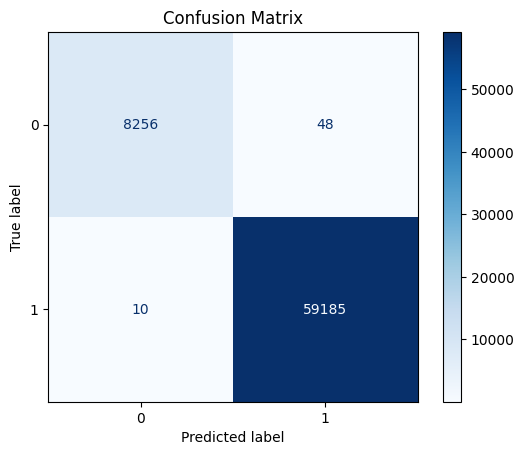

In [ ]:
evaluate_model(model_selected_gwo, test_loader_selected_gwo)

### LIME for DNN-BiLSTM with All Features

In [ ]:
explainer1 = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=X.columns.tolist(),
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
i = 10
exp1 = explainer1.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict_proba,
    num_features=X_train.shape[1]
)

In [ ]:
y_test_selected_ga.iloc[i]

0

In [ ]:
exp1.show_in_notebook(show_table=True, show_predicted_value=True)

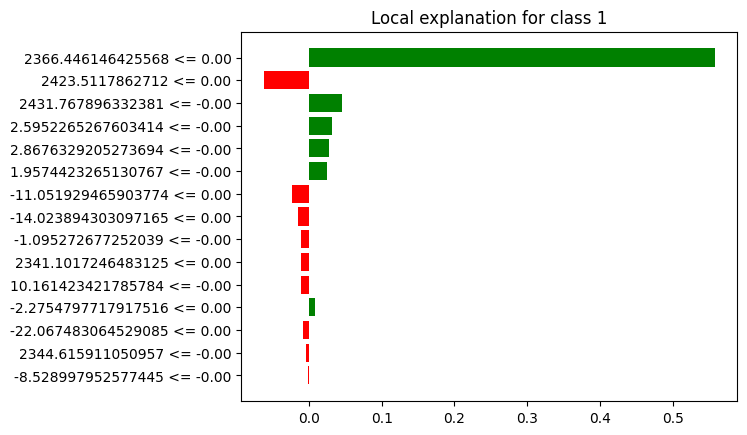

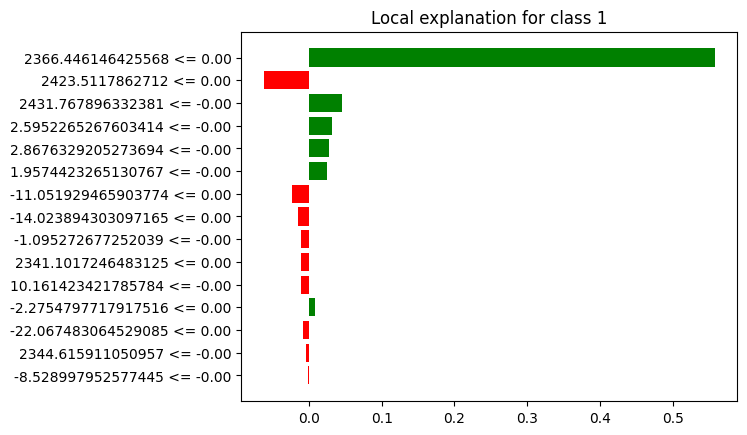

In [ ]:
exp1.as_pyplot_figure()

In [ ]:
exp1.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation.html')

In [ ]:
feature_contributions1 = exp1.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions1)

Feature Contributions (index-based): [(9, 0.5574157078249757), (3, -0.061990767877523736), (12, 0.045237892356142936), (7, 0.03192952263440116), (13, 0.0272559079151282), (1, 0.02552413175589123), (2, -0.023271513608711707), (8, -0.01531255983564288), (10, -0.010892984325808411), (6, -0.010474262925092133), (11, -0.010185107069559022), (4, 0.008294272555186874), (14, -0.008015969319778727), (0, -0.003958325168465414), (5, -0.0009016441331028202)]


### LIME for DNN-BiLSTM with GA Features

In [ ]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_ga,
                                                   feature_names=X_selected_ga,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
j=10
exp2 = explainer2.explain_instance(
    data_row=X_test_selected_ga[j],
    predict_fn=model_selected_ga.predict_proba,
    num_features=X_train_selected_ga.shape[1]
)

In [ ]:
exp2.show_in_notebook(show_table=True, show_predicted_value=True)

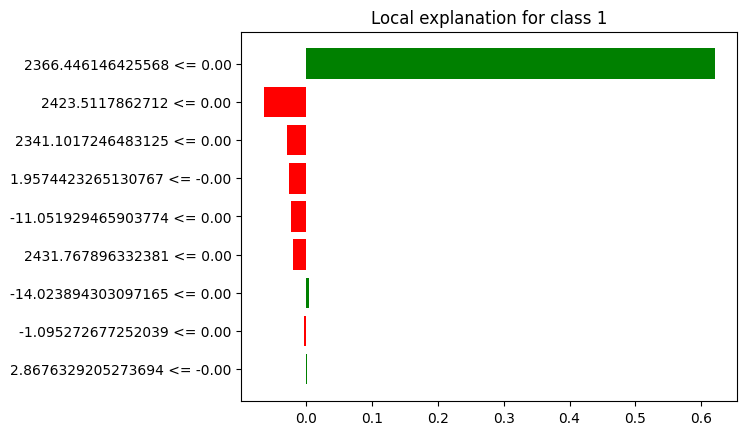

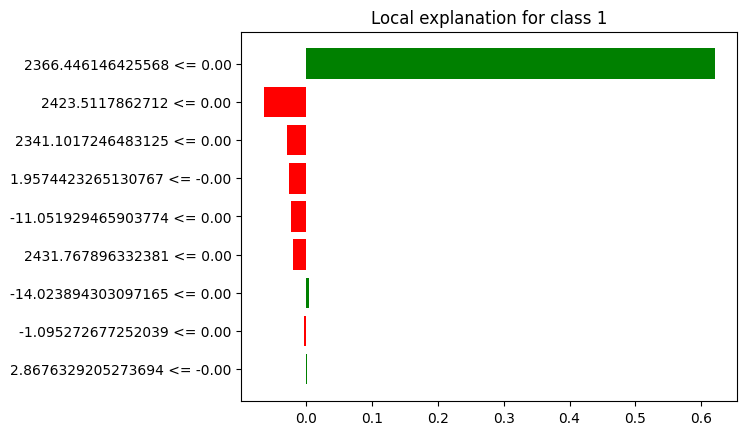

In [ ]:
exp2.as_pyplot_figure()

In [ ]:
exp2.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_ga.html')

In [ ]:
feature_contributions2 = exp2.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions2)

Feature Contributions (index-based): [(5, 0.6203313003225712), (2, -0.06419964366624208), (3, -0.029272028597404826), (0, -0.026222326634242513), (1, -0.023610096997816424), (7, -0.02024477926869089), (4, 0.004598132313239033), (6, -0.0027522067899332365), (8, 0.0010016460453038782)]


### LIME for DNN-BiLSTM with GWO Features

In [ ]:
explainer3 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_gwo,
                                                   feature_names=X_selected_gwo,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
k=10
exp3 = explainer3.explain_instance(
    data_row=X_test_selected_gwo[k],
    predict_fn=model_selected_gwo.predict_proba,
    num_features=X_train_selected_gwo.shape[1]
)

In [ ]:
exp3.show_in_notebook(show_table=True, show_predicted_value=True)

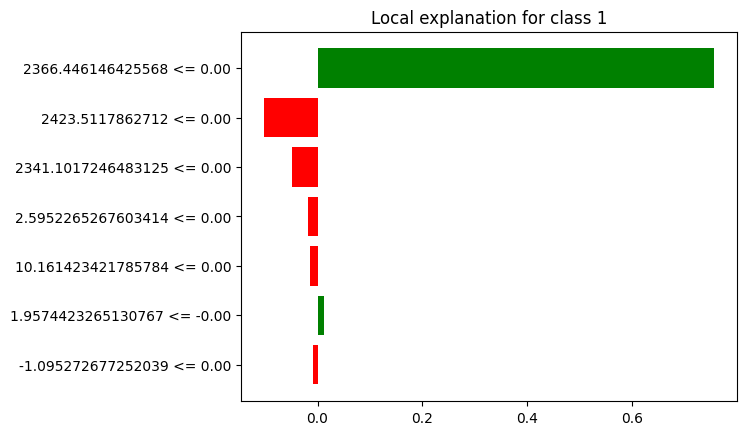

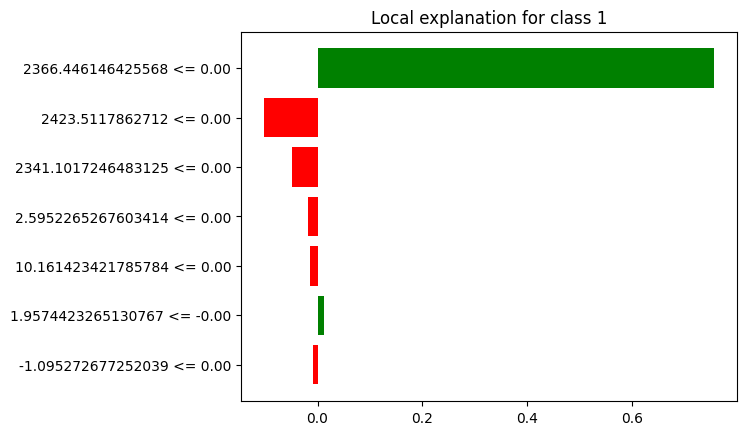

In [ ]:
exp3.as_pyplot_figure()

In [ ]:
exp3.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_gwo.html')

In [ ]:
feature_contributions3 = exp3.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions3)

Feature Contributions (index-based): [(4, 0.7563245516549879), (1, -0.10288994942274221), (2, -0.049178583940647565), (3, -0.019023428627451187), (6, -0.013968101418544944), (0, 0.012599928717331843), (5, -0.008703347392750159)]


Model Size

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth')

model_size1 = os.path.getsize('/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth') / 1024
print(f"Model Size: {model_size1:.2f} KB")

Model Size: 306.14 KB


In [ ]:
torch.save(model_selected_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_selected_model.pth')

model_size_ga = os.path.getsize('/content/drive/MyDrive/research_paper/ga_selected_model.pth') / 1024
print(f"Model Size: {model_size_ga:.2f} KB")

Model Size: 303.16 KB


In [ ]:
torch.save(model_selected_gwo.state_dict(), '/content/drive/MyDrive/research_paper/gwo_selected_model.pth')

model_size_gwo = os.path.getsize('/content/drive/MyDrive/research_paper/gwo_selected_model.pth') / 1024
print(f"Model Size: {model_size_gwo:.2f} KB")

Model Size: 302.17 KB


### Dynamic Quantization model

In [ ]:
import torch.quantization
quantized_model_ga = torch.quantization.quantize_dynamic(
    model_selected_ga,
    {nn.LSTM},
    dtype=torch.qint8
)

Test Loss: 0.030590436470817668
Test Accuracy: 0.9811
Precision: 0.9789
Recall: 1.0000
F1 Score: 0.9893
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      8304
           1       0.98      1.00      0.99     59195

    accuracy                           0.98     67499
   macro avg       0.99      0.92      0.95     67499
weighted avg       0.98      0.98      0.98     67499



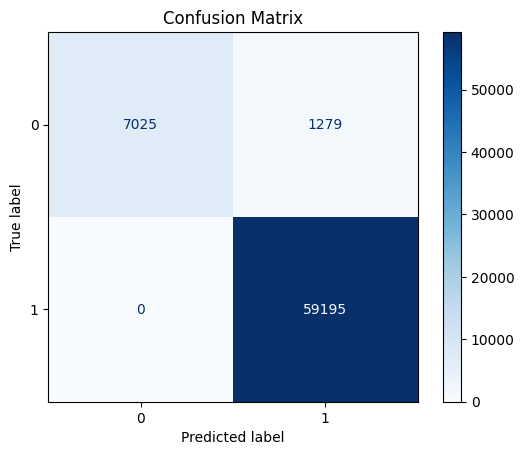

In [ ]:
evaluate_model(quantized_model_ga, test_loader_selected_ga)

In [ ]:
torch.save(quantized_model_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_quantised_model.pth')

quantized_ga_size = os.path.getsize('/content/drive/MyDrive/research_paper/ga_quantised_model.pth') / 1024
print(f"Model Size: {quantized_ga_size:.2f} KB")

Model Size: 111.92 KB


In [ ]:
quantized_model_gwo = torch.quantization.quantize_dynamic(
    model_selected_gwo,
    {nn.LSTM},
    dtype=torch.qint8
)

Test Loss: 0.00921580631216373
Test Accuracy: 0.9960
Precision: 0.9956
Recall: 0.9999
F1 Score: 0.9977
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8304
           1       1.00      1.00      1.00     59195

    accuracy                           1.00     67499
   macro avg       1.00      0.98      0.99     67499
weighted avg       1.00      1.00      1.00     67499



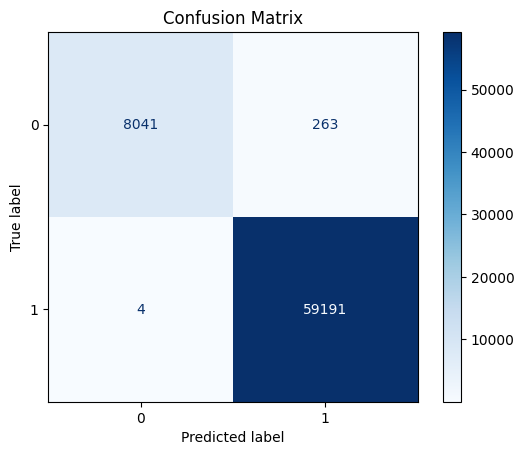

In [ ]:
evaluate_model(quantized_model_gwo, test_loader_selected_gwo)

In [ ]:
torch.save(quantized_model_gwo.state_dict(), '/content/drive/MyDrive/research_paper/gwo_quantised_model.pth')

quantized_gwo_size = os.path.getsize('/content/drive/MyDrive/research_paper/gwo_quantised_model.pth') / 1024
print(f"Model Size: {quantized_gwo_size:.2f} KB")

Model Size: 110.94 KB
